In [1]:
from perses.analysis import utils
from openmmtools.multistate import MultiStateReporter, MultiStateSamplerAnalyzer
from simtk import unit
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from perses.analysis import utils


In [2]:
# Given a path, get dg and ddg
def analyze(path):
    reporter = MultiStateReporter(path)
    analyzer = MultiStateSamplerAnalyzer(reporter)
    f_ij, df_ij = analyzer.get_free_energy()
    f = f_ij[0,-1] # units = kT
#     f = f_ij[0,-1] * analyzer.kT
#     dg = f.in_units_of(unit.kilocalories_per_mole)
    df = df_ij[0, -1]
#     df = df_ij[0, -1] * analyzer.kT
#     ddg = df.in_units_of(unit.kilocalories_per_mole)
    return f, df

def analyze_dom(path):
    reporter = MultiStateReporter(path)
    ncfile = utils.open_netcdf(path)
    n_iterations = ncfile.variables['last_iteration'][0]
    print(f"n_iterations: {n_iterations}")
    dg, ddg = list(), list()
    for step in range (1, n_iterations, 500): # add 1 because not 0-indexed -- didn't do this because the last cycle was truncated
        analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=step)
        f_ij, df_ij = analyzer.get_free_energy()
        dg.append(f_ij[0,-1])
        ddg.append(df_ij[0,-1])
    # Get final free energy
    analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=n_iterations)
    f_ij, df_ij = analyzer.get_free_energy()
    dg.append(f_ij[0,-1])
    ddg.append(df_ij[0,-1])
    return np.array(dg), np.array(ddg)

### 5 ns N501Y complex (repex/31/1/)

In [4]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [5]:
main_dir = 31
sub_dir = 1

In [6]:
for r in tqdm_notebook([0, 1, 2]):
    print (f"replicate {r}")
    output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/'
    complex_path = os.path.join(output_dir, f"{r}_complex.nc")
    print("analyzing complex")
    complex_dg, complex_ddg = analyze_dom(complex_path)
    results = np.array([complex_dg, complex_ddg])
    with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy', 'wb') as f:
        np.save(f, results)

<ipython-input-6-082b77440da6>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for r in tqdm_notebook([0, 1, 2]):


  0%|          | 0/3 [00:00<?, ?it/s]

replicate 0
analyzing complex
n_iterations: 4341


replicate 1
analyzing complex
n_iterations: 3911


replicate 2
analyzing complex
n_iterations: 4311


In [7]:
# Read the dicts in and compute free energies
import numpy as np
d_results = {}
for r in [0, 1, 2]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[r] = results
        print(f"{r}: {results[0][-1]} ({results[1][-1]}) kT")


shape: (2, 10)
array.shape: (20,)
0: 121.79737989357547 (0.8010938610450041) kT
shape: (2, 9)
array.shape: (18,)
1: 120.88578649327673 (1.271109384074034) kT
shape: (2, 10)
array.shape: (20,)
2: 118.20740301264948 (1.6633902937556202) kT


In [13]:
def plot_series(dg, ddg, r, phase, title):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(10,2*3), squeeze=True)
    for r in range(len(dg)):
        dg_discarded = dg[r][1:] # 1 * 500 = 500 ps discarded
        ddg_discarded = ddg[r][1:]
    
        # dg
        ax = axes[0]
        x = [(j)*0.5 + 0.5 for j in range(len(dg_discarded))] # *0.2 bc computing energy every 200 ps
        y = dg_discarded
        ax.plot(x, y, color=sns.color_palette()[r])
        ax.fill_between(x, y - ddg_discarded, y + ddg_discarded, alpha=0.5)

        # ddg
        ax = axes[1]
        x = [(j)*0.5 + 0.5 for j in range(len(ddg_discarded))]
        y = ddg_discarded
        ax.plot(x, y, color=sns.color_palette()[0])

    axes[0].set_ylabel("dG (kT)")
    axes[1].set_ylabel("ddG (kT)")
    axes[1].set_xlabel("$t_{repex}$ (ns)")
    
    axes[0].set_title(f"{title} {phase}")
    plt.show()
#     plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/31/1/{r}/{r}_{phase}_series.png", dpi=500)
#     plt.clf()

In [14]:
d_results

{0: array([[1.25374650e+02, 1.18904972e+02, 1.22693040e+02, 1.20998279e+02,
         1.22791137e+02, 1.21536500e+02, 1.19403992e+02, 1.19984916e+02,
         1.19909532e+02, 1.21797380e+02],
        [5.84794203e+04, 1.43091057e+00, 1.31087811e+00, 1.44393088e+00,
         8.96203048e-01, 1.29057389e+00, 1.55875117e+00, 1.45628428e+00,
         1.08247815e+00, 8.01093861e-01]]),
 1: array([[1.36976701e+02, 1.18063808e+02, 1.24065849e+02, 1.18810385e+02,
         1.18479443e+02, 1.19303433e+02, 1.17811394e+02, 1.23566992e+02,
         1.20885786e+02],
        [1.59872235e+04, 1.29740689e+00, 1.21998577e+00, 1.32488186e+00,
         1.12858100e+00, 9.91126894e-01, 1.21861352e+00, 1.09167840e+00,
         1.27110938e+00]]),
 2: array([[120.07592163, 118.83924187, 114.72757215, 114.52249662,
         107.70835827, 111.77398903, 112.29938428, 119.07831118,
         113.94390139, 118.20740301],
        [550.0927935 ,   2.48429452,   1.47809474,   1.41344533,
           0.97781567,   0.9536019

0


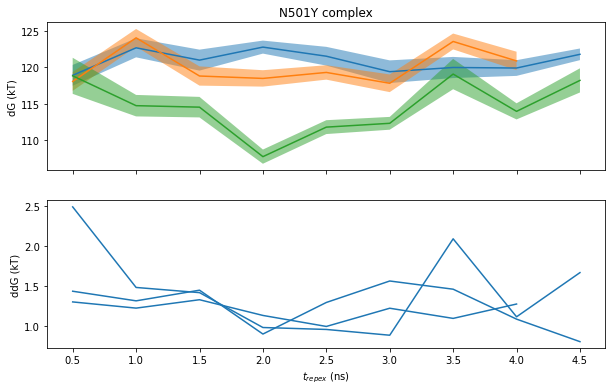

In [15]:
#### MAKE SURE TO CHANGE PATH IN PLOT_SERIES() ####

titles = ['N501Y']

# Generate dg, ddg, and discrepancy vs. time plots
for i, title in enumerate(titles):
    print(i)
    complex_dg = []
    complex_ddg = []
    for r in [0, 1, 2]:
        complex_dg.append(d_results[r][0])
        complex_ddg.append(d_results[r][1])

    plot_series(complex_dg, complex_ddg, r, 'complex', title)
    

    


In [11]:
# Generate replica mixing plots
titles = ['N501Y']
for r in [0, 1, 2]:
    print (f"replicate {r} complex")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/1/{r}/{r}_complex.nc"
    utils.plot_replica_mixing(path, title=f"{titles[i]} complex replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()


replicate 0 complex
replicate 1 complex
replicate 2 complex


<Figure size 1080x1584 with 0 Axes>

<Figure size 1080x1584 with 0 Axes>

<Figure size 1080x1584 with 0 Axes>

### 5 ns N439K complex (repex/31/2/)

In [16]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [17]:
main_dir = 31
sub_dir = 2

In [18]:
for r in tqdm_notebook([0, 1, 2]):
    print (f"replicate {r}")
    output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/'
    complex_path = os.path.join(output_dir, f"{r}_complex.nc")
    print("analyzing complex")
    complex_dg, complex_ddg = analyze_dom(complex_path)
    results = np.array([complex_dg, complex_ddg])
    with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy', 'wb') as f:
        np.save(f, results)

<ipython-input-18-082b77440da6>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for r in tqdm_notebook([0, 1, 2]):


  0%|          | 0/3 [00:00<?, ?it/s]

replicate 0
analyzing complex
n_iterations: 3476


replicate 1
analyzing complex
n_iterations: 4810


replicate 2
analyzing complex
n_iterations: 4957


In [19]:
# Read the dicts in and compute free energies
import numpy as np
d_results = {}
for r in [0, 1, 2]:
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{r}/results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        d_results[r] = results
        print(f"{r}: {results[0][-1]} ({results[1][-1]}) kT")


shape: (2, 8)
array.shape: (16,)
0: -25.013264973049118 (1.153357493051699) kT
shape: (2, 11)
array.shape: (22,)
1: -18.19309717388876 (0.9457393850184148) kT
shape: (2, 11)
array.shape: (22,)
2: -22.586815965414203 (0.7877438909857486) kT


In [24]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [20]:
def plot_series(dg, ddg, r, phase, title):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(10,2*3), squeeze=True)
    for r in range(len(dg)):
        dg_discarded = dg[r][1:] # 1 * 500 = 500 ps discarded
        ddg_discarded = ddg[r][1:]
    
        # dg
        ax = axes[0]
        x = [(j)*0.5 + 0.5 for j in range(len(dg_discarded))] # *0.2 bc computing energy every 200 ps
        y = dg_discarded
        ax.plot(x, y, color=sns.color_palette()[r])
        ax.fill_between(x, y - ddg_discarded, y + ddg_discarded, alpha=0.5)

        # ddg
        ax = axes[1]
        x = [(j)*0.5 + 0.5 for j in range(len(ddg_discarded))]
        y = ddg_discarded
        ax.plot(x, y, color=sns.color_palette()[0])

    axes[0].set_ylabel("dG (kT)")
    axes[1].set_ylabel("ddG (kT)")
    axes[1].set_xlabel("$t_{repex}$ (ns)")
    
    axes[0].set_title(f"{title} {phase}")
    plt.show()
#     plt.savefig(f"/data/chodera/zhangi/perses_benchmark/repex/31/1/{r}/{r}_{phase}_series.png", dpi=500)
#     plt.clf()

In [21]:
d_results

{0: array([[ 1.76030515e+01, -2.43708221e+01, -2.41413142e+01,
         -2.32016128e+01, -2.64498925e+01, -2.28058433e+01,
         -2.00110270e+01, -2.50132650e+01],
        [ 5.61640650e+03,  2.18397487e+00,  1.24496936e+00,
          1.36582765e+00,  1.60924081e+00,  1.62892212e+00,
          1.23977054e+00,  1.15335749e+00]]),
 1: array([[  4.37905136, -30.46977265, -23.1353227 , -24.36580037,
         -26.36684098, -26.35098806, -21.43762907, -22.77031495,
         -20.14124153, -20.66905928, -18.19309717],
        [102.61119767,   2.04230889,   1.50728859,   1.44533344,
           1.52366432,   1.23443749,   1.33123098,   1.25623766,
           0.95246153,   0.90501066,   0.94573939]]),
 2: array([[ 6.62894791e+00, -2.46591873e+01, -2.92757869e+01,
         -1.99803062e+01, -2.17799789e+01, -2.17849019e+01,
         -2.17126846e+01, -2.22483655e+01, -2.30002049e+01,
         -2.46622463e+01, -2.25868160e+01],
        [ 2.79407081e+03,  2.11494827e+00,  1.59545817e+00,
          1

0


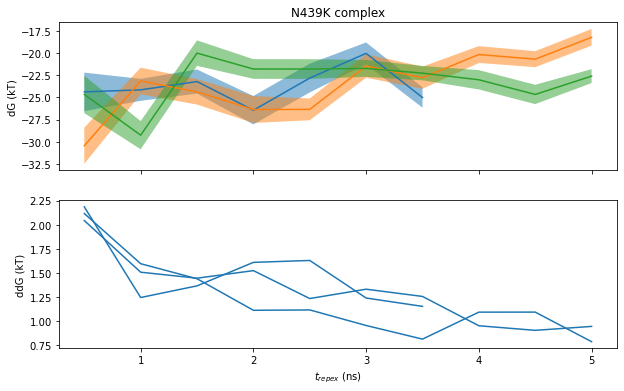

In [22]:
#### MAKE SURE TO CHANGE PATH IN PLOT_SERIES() ####

titles = ['N439K']

# Generate dg, ddg, and discrepancy vs. time plots
for i, title in enumerate(titles):
    print(i)
    complex_dg = []
    complex_ddg = []
    for r in [0, 1, 2]:
        complex_dg.append(d_results[r][0])
        complex_ddg.append(d_results[r][1])

    plot_series(complex_dg, complex_ddg, r, 'complex', title)
    

    


In [23]:
# Generate replica mixing plots
titles = ['N439K']
for r in [0, 1, 2]:
    print (f"replicate {r} complex")
    path = f"/data/chodera/zhangi/perses_benchmark/repex/31/1/{r}/{r}_complex.nc"
    utils.plot_replica_mixing(path, title=f"{titles[i]} complex replicate {r}", filename=f"{path[:-3]}_replicas.png")
    plt.clf()


replicate 0 complex
replicate 1 complex
replicate 2 complex


<Figure size 1080x1584 with 0 Axes>

<Figure size 1080x1584 with 0 Axes>

<Figure size 1080x1584 with 0 Axes>